In [1]:
# 🔧 IMPORT REQUIRED LIBRARIES
# ============================

# Core data analysis
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

# Enhanced plotting (optional - graceful fallback if not available)
try:
    import seaborn as sns
    sns.set_style("whitegrid")
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("📦 Seaborn not available - using matplotlib defaults")

try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    import plotly.offline as pyo
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False
    print("📦 Plotly not available - using matplotlib only")

# Custom utilities
import utils.nucleus1000dvl_analysis as dvl_utils

# Configuration
warnings.filterwarnings('ignore', category=FutureWarning)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print(f"📊 Enhanced visualization: Seaborn={HAS_SEABORN}, Plotly={HAS_PLOTLY}")


✅ Libraries imported successfully!
📊 Enhanced visualization: Seaborn=True, Plotly=True


In [2]:
# 🔍 CONFIGURATION PARAMETERS
# ===========================
# Modify these parameters to customize the analysis

# Data source configuration
BY_BAG_FOLDER = "exports/by_bag"  # Path to CSV files

# Visualization preferences
PLOT_STYLE = "interactive" if HAS_PLOTLY else "static"  # 'interactive' or 'static'
FIGURE_SIZE = (12, 8)  # Default figure size for matplotlib
COLOR_PALETTE = "Set1"  # Color palette for plots

# Analysis parameters  
BAG_SELECTION = None  # None for all bags, or specify like "2024-08-22_14-06-43"
SENSOR_SELECTION = None  # None for all sensors, or specify like ["bottomtrack", "ins"]

# Export settings
EXPORT_SUMMARY = True  # Export data summary to CSV
EXPORT_PLOTS = False   # Save plots to files
OUTPUT_FOLDER = "exports/outputs"  # Output folder for exports

print("⚙️  Configuration loaded:")
print(f"   📂 Data folder: {BY_BAG_FOLDER}")
print(f"   🎨 Plot style: {PLOT_STYLE}")
print(f"   📅 Bag selection: {BAG_SELECTION or 'All bags'}")
print(f"   🔧 Sensor selection: {SENSOR_SELECTION or 'All sensors'}")
print(f"   💾 Export summary: {EXPORT_SUMMARY}")
print(f"   📊 Export plots: {EXPORT_PLOTS}")

⚙️  Configuration loaded:
   📂 Data folder: exports/by_bag
   🎨 Plot style: interactive
   📅 Bag selection: All bags
   🔧 Sensor selection: All sensors
   💾 Export summary: True
   📊 Export plots: False


In [3]:
# 🔍 FILE DISCOVERY AND DATA LOADING
# ==================================

print("🔍 Discovering Nucleus1000DVL data files...")

# Initialize the analyzer
analyzer = dvl_utils.Nucleus1000DVLAnalyzer(BY_BAG_FOLDER)

print(f"\n📋 Data Discovery Summary:")
print(f"   📅 Available bags: {len(analyzer.available_bags)}")
print(f"   🔧 Available sensors: {len(analyzer.available_sensors)}")

if analyzer.available_bags:
    print(f"\n📅 Bags found:")
    for bag in analyzer.available_bags:
        print(f"   • {bag}")

if analyzer.available_sensors:
    print(f"\n🔧 Sensors found:")
    for sensor in analyzer.available_sensors:
        print(f"   • {sensor}")

# Get detailed summary
print(f"\n📊 Detailed data summary:")
analyzer.get_summary()

🔍 Discovering Nucleus1000DVL data files...
🔍 Found DVL data:
   📅 Bags: 3
   📊 Sensors: 6
   Sensors: altimeter, bottomtrack, imu, ins, magnetometer, watertrack

📋 Data Discovery Summary:
   📅 Available bags: 3
   🔧 Available sensors: 6

📅 Bags found:
   • 2024-08-22_14-06-43
   • 2024-08-22_14-29-05
   • 2024-08-22_14-47-39

🔧 Sensors found:
   • altimeter
   • bottomtrack
   • imu
   • ins
   • magnetometer
   • watertrack

📊 Detailed data summary:
📊 Nucleus1000DVL Data Summary

🔧 ALTIMETER:
   📅 2024-08-22_14-06-43: 17 samples, 0.6 min
   📅 2024-08-22_14-29-05: 31 samples, 1.0 min
   📅 2024-08-22_14-47-39: 20 samples, 0.7 min

🔧 BOTTOMTRACK:
   📅 2024-08-22_14-06-43: 52 samples, 0.6 min
   📅 2024-08-22_14-29-05: 81 samples, 1.0 min
   📅 2024-08-22_14-47-39: 62 samples, 0.7 min

🔧 IMU:
   📅 2024-08-22_14-06-43: 3580 samples, 0.6 min
   📅 2024-08-22_14-29-05: 6034 samples, 1.0 min
   📅 2024-08-22_14-47-39: 4400 samples, 0.7 min

🔧 INS:
   📅 2024-08-22_14-06-43: 366 samples, 0.6 min
  

In [4]:
# 📊 BASIC DATA EXPLORATION
# =========================

print("📊 Exploring data structure and content...")

# Select bag for detailed exploration
if BAG_SELECTION and BAG_SELECTION in analyzer.available_bags:
    selected_bag = BAG_SELECTION
elif analyzer.available_bags:
    selected_bag = analyzer.available_bags[0]  # Use first available bag
    print(f"📅 Auto-selected bag: {selected_bag}")
else:
    print("❌ No bags available for analysis")
    selected_bag = None

if selected_bag:
    print(f"\n🔍 Exploring bag: {selected_bag}")
    
    # Load and explore each sensor type
    for sensor in analyzer.available_sensors:
        print(f"\n🔧 {sensor.upper()} Data:")
        
        data = analyzer.load_sensor_data(sensor, selected_bag, verbose=False)
        
        if data is not None and len(data) > 0:
            print(f"   📏 Shape: {data.shape}")
            print(f"   ⏱️  Duration: {data['t_rel'].max()/60:.1f} minutes")
            print(f"   📊 Sample rate: {len(data)/(data['t_rel'].max()):.1f} Hz")
            
            # Show key columns
            key_cols = []
            if sensor == 'bottomtrack':
                key_cols = ['dvl_velocity_xyz.x', 'dvl_velocity_xyz.y', 'dvl_velocity_xyz.z', 'data_valid']
            elif sensor == 'ins':
                key_cols = ['positionFrame.x', 'positionFrame.y', 'velocityNed.x', 'velocityNed.y']
            elif sensor == 'altimeter':
                key_cols = ['altimeter_distance', 'altimeter_quality']
            elif sensor == 'imu':
                key_cols = ['linear_acceleration.x', 'angular_velocity.z']
            
            available_key_cols = [col for col in key_cols if col in data.columns]
            if available_key_cols:
                print(f"   🔑 Key data preview:")
                for col in available_key_cols[:3]:  # Show first 3 key columns
                    if data[col].dtype in ['float64', 'int64']:
                        print(f"      {col}: {data[col].mean():.3f} ± {data[col].std():.3f}")
        else:
            print(f"   ❌ No data available")

print(f"\n✅ Data exploration complete!")


📊 Exploring data structure and content...
📅 Auto-selected bag: 2024-08-22_14-06-43

🔍 Exploring bag: 2024-08-22_14-06-43

🔧 ALTIMETER Data:
   📏 Shape: (17, 21)
   ⏱️  Duration: 0.6 minutes
   📊 Sample rate: 0.5 Hz
   🔑 Key data preview:
      altimeter_distance: 0.071 ± 0.294
      altimeter_quality: 15793.118 ± 345.703

🔧 BOTTOMTRACK Data:
   📏 Shape: (52, 35)
   ⏱️  Duration: 0.6 minutes
   📊 Sample rate: 1.5 Hz
   🔑 Key data preview:
      dvl_velocity_xyz.x: -3.016 ± 9.799
      dvl_velocity_xyz.y: -3.167 ± 9.749
      dvl_velocity_xyz.z: -3.141 ± 9.758

🔧 IMU Data:
   📏 Shape: (3580, 24)
   ⏱️  Duration: 0.6 minutes
   📊 Sample rate: 95.5 Hz

🔧 INS Data:
   📏 Shape: (366, 50)
   ⏱️  Duration: 0.6 minutes
   📊 Sample rate: 9.6 Hz
   🔑 Key data preview:
      positionFrame.x: 4.422 ± 1.479
      positionFrame.y: 10.345 ± 0.890
      velocityNed.x: 0.118 ± 0.070

🔧 MAGNETOMETER Data:
   📏 Shape: (2039, 20)
   ⏱️  Duration: 0.6 minutes
   📊 Sample rate: 55.5 Hz

🔧 WATERTRACK Data:
  

In [5]:
# 🚀 BOTTOM TRACK VELOCITY VISUALIZATION
# ======================================

print("🚀 Creating bottom track velocity visualizations...")

# Plot bottom track velocity for selected bag(s)
if 'bottomtrack' in analyzer.available_sensors:
    
    if BAG_SELECTION:
        print(f"📊 Plotting bottom track velocity for bag: {BAG_SELECTION}")
        analyzer.plot_bottomtrack_velocity(BAG_SELECTION, interactive=(PLOT_STYLE == "interactive"))
    else:
        print(f"📊 Plotting bottom track velocity for all bags")
        analyzer.plot_bottomtrack_velocity(None, interactive=(PLOT_STYLE == "interactive"))
    
    print("✅ Bottom track velocity plots complete!")
    
else:
    print("⚠️  No bottom track data available")

🚀 Creating bottom track velocity visualizations...
📊 Plotting bottom track velocity for all bags


✅ Bottom track velocity plots complete!


In [7]:
# 🗺️ SPATIAL DATA VISUALIZATION - TRAJECTORIES  
# =============================================

print("🗺️ Creating vehicle trajectory visualizations...")

# Plot 2D trajectory from INS data
if 'ins' in analyzer.available_sensors:
    
    if BAG_SELECTION:
        print(f"📍 Plotting trajectory for bag: {BAG_SELECTION}")
        analyzer.plot_trajectory_2d(BAG_SELECTION, interactive=(PLOT_STYLE == "interactive"))
    else:
        print(f"📍 Plotting trajectories for all bags")
        analyzer.plot_trajectory_2d(None, interactive=(PLOT_STYLE == "interactive"))
    
    print("✅ Trajectory plots complete!")
    
else:
    print("⚠️  No INS data available for trajectory plotting")

🗺️ Creating vehicle trajectory visualizations...
📍 Plotting trajectories for all bags


✅ Trajectory plots complete!


In [8]:
# 🧭 INS DATA VISUALIZATION
# =========================

print("🧭 Creating INS (Inertial Navigation System) visualizations...")

# Plot INS data (position, velocity, orientation)
if 'ins' in analyzer.available_sensors:
    
    # Select variables to plot
    ins_variables = ['position', 'velocity', 'quaternion']
    
    if BAG_SELECTION:
        print(f"📊 Plotting INS data for bag: {BAG_SELECTION}")
        analyzer.plot_ins_data(BAG_SELECTION, variables=ins_variables, 
                             interactive=(PLOT_STYLE == "interactive"))
    else:
        # Plot for first available bag
        first_bag = analyzer.available_bags[0] if analyzer.available_bags else None
        if first_bag:
            print(f"📊 Plotting INS data for bag: {first_bag}")
            analyzer.plot_ins_data(first_bag, variables=ins_variables,
                                 interactive=(PLOT_STYLE == "interactive"))
    
    print("✅ INS data plots complete!")
    
else:
    print("⚠️  No INS data available")

🧭 Creating INS (Inertial Navigation System) visualizations...
📊 Plotting INS data for bag: 2024-08-22_14-06-43


✅ INS data plots complete!


📈 Creating multi-file comparison analysis...
📊 Comparing data across 3 bags
🔄 Comparing bottom track velocities...


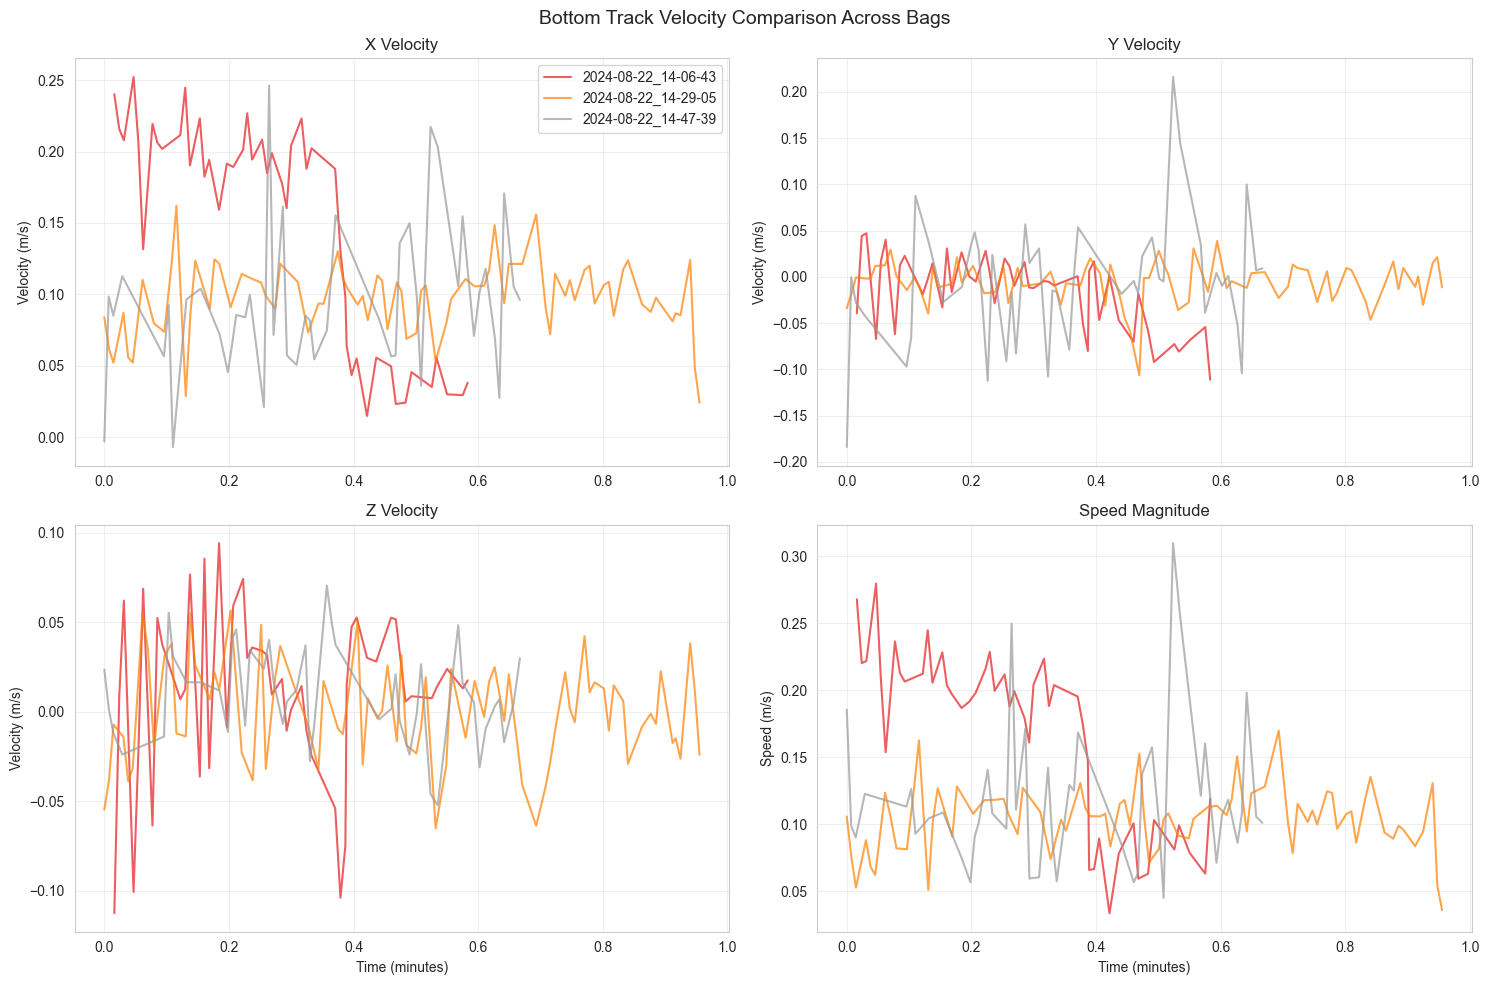

✅ Multi-file comparison complete!


In [9]:
# 📈 MULTI-FILE COMPARISON ANALYSIS
# =================================

print("📈 Creating multi-file comparison analysis...")

# Create custom comparison plots for multiple bags
if len(analyzer.available_bags) > 1:
    
    print(f"📊 Comparing data across {len(analyzer.available_bags)} bags")
    
    # Compare bottom track velocities across bags
    if 'bottomtrack' in analyzer.available_sensors:
        print("🔄 Comparing bottom track velocities...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Bottom Track Velocity Comparison Across Bags', fontsize=14)
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(analyzer.available_bags)))
        
        for i, bag in enumerate(analyzer.available_bags):
            data = analyzer.load_sensor_data("bottomtrack", bag, verbose=False)
            
            if isinstance(data, dict):
                data = data.get(bag)
            
            if data is not None and 'dvl_velocity_xyz.x' in data.columns:
                # Filter valid data
                valid_mask = data.get('data_valid', pd.Series([True] * len(data))) == True
                data_valid = data[valid_mask]
                
                if len(data_valid) > 0:
                    color = colors[i]
                    
                    # X velocity
                    axes[0,0].plot(data_valid['t_rel_min'], data_valid['dvl_velocity_xyz.x'], 
                                 color=color, label=bag, alpha=0.7)
                    
                    # Y velocity  
                    axes[0,1].plot(data_valid['t_rel_min'], data_valid['dvl_velocity_xyz.y'], 
                                 color=color, alpha=0.7)
                    
                    # Z velocity
                    axes[1,0].plot(data_valid['t_rel_min'], data_valid['dvl_velocity_xyz.z'], 
                                 color=color, alpha=0.7)
                    
                    # Speed magnitude
                    speed = np.sqrt(data_valid['dvl_velocity_xyz.x']**2 + 
                                  data_valid['dvl_velocity_xyz.y']**2 + 
                                  data_valid['dvl_velocity_xyz.z']**2)
                    axes[1,1].plot(data_valid['t_rel_min'], speed, 
                                 color=color, alpha=0.7)
        
        # Format subplots
        axes[0,0].set_title('X Velocity')
        axes[0,0].set_ylabel('Velocity (m/s)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        axes[0,1].set_title('Y Velocity')
        axes[0,1].set_ylabel('Velocity (m/s)')
        axes[0,1].grid(True, alpha=0.3)
        
        axes[1,0].set_title('Z Velocity')
        axes[1,0].set_ylabel('Velocity (m/s)')
        axes[1,0].set_xlabel('Time (minutes)')
        axes[1,0].grid(True, alpha=0.3)
        
        axes[1,1].set_title('Speed Magnitude')
        axes[1,1].set_ylabel('Speed (m/s)')
        axes[1,1].set_xlabel('Time (minutes)')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if EXPORT_PLOTS:
            output_path = Path(OUTPUT_FOLDER) / "bottomtrack_comparison.png"
            output_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"💾 Saved plot: {output_path}")
        
        plt.show()
    
    print("✅ Multi-file comparison complete!")
    
else:
    print("⚠️  Only one bag available - skipping comparison analysis")


In [10]:

# 📊 STATISTICAL SUMMARY AND METRICS
# ==================================

print("📊 Calculating statistical summary and metrics...")

# Calculate summary statistics for all sensors and bags
summary_stats = []

for sensor in analyzer.available_sensors:
    print(f"\n🔧 {sensor.upper()} Statistics:")
    
    for bag in analyzer.available_bags:
        data = analyzer.load_sensor_data(sensor, bag, verbose=False)
        
        if isinstance(data, dict):
            data = data.get(bag)
        
        if data is not None and len(data) > 0:
            
            # Basic stats
            duration_min = data['t_rel'].max() / 60.0 if 't_rel' in data.columns else 0
            sample_rate = len(data) / data['t_rel'].max() if 't_rel' in data.columns and data['t_rel'].max() > 0 else 0
            
            stats = {
                'sensor': sensor,
                'bag': bag,
                'samples': len(data),
                'duration_min': duration_min,
                'sample_rate_hz': sample_rate
            }
            
            # Sensor-specific statistics
            if sensor == 'bottomtrack' and 'dvl_velocity_xyz.x' in data.columns:
                # Filter valid data
                valid_mask = data.get('data_valid', pd.Series([True] * len(data))) == True
                data_valid = data[valid_mask]
                
                if len(data_valid) > 0:
                    # Velocity statistics
                    vx_mean = data_valid['dvl_velocity_xyz.x'].mean()
                    vy_mean = data_valid['dvl_velocity_xyz.y'].mean() 
                    vz_mean = data_valid['dvl_velocity_xyz.z'].mean()
                    
                    speed = np.sqrt(data_valid['dvl_velocity_xyz.x']**2 + 
                                  data_valid['dvl_velocity_xyz.y']**2 + 
                                  data_valid['dvl_velocity_xyz.z']**2)
                    
                    stats.update({
                        'mean_vx': vx_mean,
                        'mean_vy': vy_mean,
                        'mean_vz': vz_mean,
                        'mean_speed': speed.mean(),
                        'max_speed': speed.max(),
                        'std_speed': speed.std(),
                        'valid_data_percent': len(data_valid) / len(data) * 100
                    })
                    
                    print(f"   📅 {bag}:")
                    print(f"      💨 Mean speed: {speed.mean():.3f} ± {speed.std():.3f} m/s")
                    print(f"      🚀 Max speed: {speed.max():.3f} m/s")
                    print(f"      ✅ Valid data: {len(data_valid)/len(data)*100:.1f}%")
            
            elif sensor == 'ins' and 'positionFrame.x' in data.columns:
                # Position and trajectory statistics
                pos_x_range = data['positionFrame.x'].max() - data['positionFrame.x'].min()
                pos_y_range = data['positionFrame.y'].max() - data['positionFrame.y'].min()
                
                # Calculate total distance traveled
                dx = np.diff(data['positionFrame.x'])
                dy = np.diff(data['positionFrame.y'])
                distances = np.sqrt(dx**2 + dy**2)
                total_distance = distances.sum()
                
                stats.update({
                    'pos_x_range': pos_x_range,
                    'pos_y_range': pos_y_range,
                    'total_distance': total_distance,
                    'mean_pos_x': data['positionFrame.x'].mean(),
                    'mean_pos_y': data['positionFrame.y'].mean()
                })
                
                print(f"   📅 {bag}:")
                print(f"      📍 Position range: X={pos_x_range:.2f}m, Y={pos_y_range:.2f}m")
                print(f"      🛣️  Total distance: {total_distance:.2f}m")
            
            elif sensor == 'altimeter' and 'altimeter_distance' in data.columns:
                # Altimeter statistics
                alt_mean = data['altimeter_distance'].mean()
                alt_std = data['altimeter_distance'].std()
                alt_min = data['altimeter_distance'].min()
                alt_max = data['altimeter_distance'].max()
                
                stats.update({
                    'mean_altitude': alt_mean,
                    'std_altitude': alt_std,
                    'min_altitude': alt_min,
                    'max_altitude': alt_max
                })
                
                print(f"   📅 {bag}:")
                print(f"      🌊 Altitude: {alt_mean:.2f} ± {alt_std:.2f}m")
                print(f"      📏 Range: {alt_min:.2f} - {alt_max:.2f}m")
            
            summary_stats.append(stats)

# Create summary DataFrame
if summary_stats:
    summary_df = pd.DataFrame(summary_stats)
    
    print(f"\n📋 Overall Summary:")
    print(f"   📊 Total datasets: {len(summary_df)}")
    print(f"   ⏱️  Total duration: {summary_df['duration_min'].sum():.1f} minutes")
    
    # Display summary table
    print(f"\n📊 Summary Table:")
    display(summary_df.head(10))
    
    # Export summary if requested
    if EXPORT_SUMMARY:
        output_path = Path(OUTPUT_FOLDER) / "nucleus1000dvl_detailed_summary.csv"
        output_path.parent.mkdir(parents=True, exist_ok=True)
        summary_df.to_csv(output_path, index=False)
        print(f"💾 Summary exported to: {output_path}")

print("✅ Statistical analysis complete!")


📊 Calculating statistical summary and metrics...

🔧 ALTIMETER Statistics:
   📅 2024-08-22_14-06-43:
      🌊 Altitude: 0.07 ± 0.29m
      📏 Range: 0.00 - 1.21m
   📅 2024-08-22_14-29-05:
      🌊 Altitude: 0.03 ± 0.13m
      📏 Range: 0.00 - 0.55m
   📅 2024-08-22_14-47-39:
      🌊 Altitude: 0.19 ± 0.63m
      📏 Range: 0.00 - 2.54m

🔧 BOTTOMTRACK Statistics:
   📅 2024-08-22_14-06-43:
      💨 Mean speed: 0.168 ± 0.064 m/s
      🚀 Max speed: 0.280 m/s
      ✅ Valid data: 90.4%
   📅 2024-08-22_14-29-05:
      💨 Mean speed: 0.104 ± 0.024 m/s
      🚀 Max speed: 0.170 m/s
      ✅ Valid data: 98.8%
   📅 2024-08-22_14-47-39:
      💨 Mean speed: 0.119 ± 0.054 m/s
      🚀 Max speed: 0.310 m/s
      ✅ Valid data: 74.2%

🔧 IMU Statistics:

🔧 INS Statistics:
   📅 2024-08-22_14-06-43:
      📍 Position range: X=4.36m, Y=2.94m
      🛣️  Total distance: 5.95m
   📅 2024-08-22_14-29-05:
      📍 Position range: X=4.97m, Y=2.67m
      🛣️  Total distance: 5.91m
   📅 2024-08-22_14-47-39:
      📍 Position range: X

,sensor,bag,samples,duration_min,sample_rate_hz,mean_altitude,std_altitude,min_altitude,max_altitude,mean_vx,...,mean_vz,mean_speed,max_speed,std_speed,valid_data_percent,pos_x_range,pos_y_range,total_distance,mean_pos_x,mean_pos_y
0,altimeter,2024-08-22_14-06-43,17,0.564162,0.502220,0.071370,0.294267,0.0,1.213295,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,altimeter,2024-08-22_14-29-05,31,1.002527,0.515364,0.034753,0.134554,0.0,0.549783,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,altimeter,2024-08-22_14-47-39,20,0.666027,0.500480,0.194140,0.627895,0.0,2.535765,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bottomtrack,2024-08-22_14-06-43,52,0.583144,1.486196,NaN,NaN,NaN,NaN,0.149354,...,0.011192,0.168106,0.279687,0.064454,90.384615,NaN,NaN,NaN,NaN,NaN
4,bottomtrack,2024-08-22_14-29-05,81,0.955224,1.413281,NaN,NaN,NaN,NaN,0.097312,...,-0.000235,0.103959,0.169978,0.023894,98.765432,NaN,NaN,NaN,NaN,NaN
5,bottomtrack,2024-08-22_14-47-39,62,0.666893,1.549473,NaN,NaN,NaN,NaN,0.093950,...,0.009455,0.118712,0.309935,0.054261,74.193548,NaN,NaN,NaN,NaN,NaN
6,imu,2024-08-22_14-06-43,3580,0.624660,95.518665,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,imu,2024-08-22_14-29-05,6034,1.047727,95.985590,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,imu,2024-08-22_14-47-39,4400,0.746314,98.260668,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ins,2024-08-22_14-06-43,366,0.637416,9.569885,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.355668,2.939591,5.947814,4.421946,10.344578


💾 Summary exported to: exports/outputs/nucleus1000dvl_detailed_summary.csv
✅ Statistical analysis complete!


In [11]:
# 🎛️ INTERACTIVE DASHBOARD CREATION
# =================================

print("🎛️ Creating interactive dashboard...")

if HAS_PLOTLY and analyzer.available_bags:
    
    # Select bag for dashboard
    dashboard_bag = BAG_SELECTION if BAG_SELECTION in analyzer.available_bags else analyzer.available_bags[0]
    
    print(f"📊 Creating dashboard for bag: {dashboard_bag}")
    
    # Create comprehensive dashboard
    try:
        dashboard_fig = dvl_utils.create_comprehensive_dvl_dashboard(
            analyzer, 
            bag_name=dashboard_bag,
            output_html="nucleus1000dvl_dashboard.html"
        )
        
        print("✅ Interactive dashboard created!")
        print("🌐 Dashboard saved to exports/outputs/nucleus1000dvl_dashboard.html")
        
        # Display the dashboard in notebook
        if dashboard_fig:
            dashboard_fig.show()
        
    except Exception as e:
        print(f"⚠️  Dashboard creation failed: {e}")
        print("   Falling back to static plots")

else:
    print("⚠️  Interactive dashboard requires Plotly - using static plots instead")
    
    # Create static dashboard alternative
    if analyzer.available_bags:
        selected_bag = analyzer.available_bags[0]
        print(f"📊 Creating static overview for bag: {selected_bag}")
        
        # Create a 2x2 subplot layout
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Nucleus1000DVL Overview - {selected_bag}', fontsize=16)
        
        # Bottom track velocity (if available)
        if 'bottomtrack' in analyzer.available_sensors:
            data = analyzer.load_sensor_data("bottomtrack", selected_bag, verbose=False)
            if isinstance(data, dict):
                data = data.get(selected_bag)
            
            if data is not None and 'dvl_velocity_xyz.x' in data.columns:
                valid_mask = data.get('data_valid', pd.Series([True] * len(data))) == True
                data_valid = data[valid_mask]
                
                if len(data_valid) > 0:
                    axes[0,0].plot(data_valid['t_rel_min'], data_valid['dvl_velocity_xyz.x'], 'r-', alpha=0.7, label='X')
                    axes[0,0].plot(data_valid['t_rel_min'], data_valid['dvl_velocity_xyz.y'], 'g-', alpha=0.7, label='Y')
                    axes[0,0].plot(data_valid['t_rel_min'], data_valid['dvl_velocity_xyz.z'], 'b-', alpha=0.7, label='Z')
                    axes[0,0].set_title('Bottom Track Velocity')
                    axes[0,0].set_ylabel('Velocity (m/s)')
                    axes[0,0].legend()
                    axes[0,0].grid(True, alpha=0.3)
        
        # INS trajectory (if available)
        if 'ins' in analyzer.available_sensors:
            data = analyzer.load_sensor_data("ins", selected_bag, verbose=False)
            if isinstance(data, dict):
                data = data.get(selected_bag)
            
            if data is not None and 'positionFrame.x' in data.columns:
                axes[0,1].plot(data['positionFrame.x'], data['positionFrame.y'], 'b-', alpha=0.7)
                axes[0,1].scatter(data['positionFrame.x'].iloc[0], data['positionFrame.y'].iloc[0], 
                                c='green', s=100, marker='s', label='Start')
                axes[0,1].scatter(data['positionFrame.x'].iloc[-1], data['positionFrame.y'].iloc[-1], 
                                c='red', s=100, marker='D', label='End')
                axes[0,1].set_title('Vehicle Trajectory')
                axes[0,1].set_xlabel('X Position (m)')
                axes[0,1].set_ylabel('Y Position (m)')
                axes[0,1].legend()
                axes[0,1].grid(True, alpha=0.3)
                axes[0,1].set_aspect('equal', adjustable='box')
        
        # Altimeter (if available)
        if 'altimeter' in analyzer.available_sensors:
            data = analyzer.load_sensor_data("altimeter", selected_bag, verbose=False)
            if isinstance(data, dict):
                data = data.get(selected_bag)
            
            if data is not None and 'altimeter_distance' in data.columns:
                axes[1,0].plot(data['t_rel_min'], data['altimeter_distance'], 'purple', alpha=0.7)
                axes[1,0].set_title('Altimeter Distance')
                axes[1,0].set_ylabel('Distance (m)')
                axes[1,0].set_xlabel('Time (minutes)')
                axes[1,0].grid(True, alpha=0.3)
        
        # Data summary plot
        if summary_stats:
            sensors = [s['sensor'] for s in summary_stats if s['bag'] == selected_bag]
            durations = [s['duration_min'] for s in summary_stats if s['bag'] == selected_bag]
            
            if sensors and durations:
                axes[1,1].bar(sensors, durations, alpha=0.7)
                axes[1,1].set_title('Data Duration by Sensor')
                axes[1,1].set_ylabel('Duration (minutes)')
                axes[1,1].tick_params(axis='x', rotation=45)
                axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if EXPORT_PLOTS:
            output_path = Path(OUTPUT_FOLDER) / f"nucleus1000dvl_overview_{selected_bag}.png"
            output_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"💾 Saved overview plot: {output_path}")
        
        plt.show()

print("✅ Dashboard creation complete!")


🎛️ Creating interactive dashboard...
📊 Creating dashboard for bag: 2024-08-22_14-06-43
📊 Dashboard saved to: exports/outputs/nucleus1000dvl_dashboard.html
✅ Interactive dashboard created!
🌐 Dashboard saved to exports/outputs/nucleus1000dvl_dashboard.html


✅ Dashboard creation complete!


In [18]:
# 📊 DVL SENSOR COMPARISON ANALYSIS
# =================================
# Compare nucleus1000dvl bottomtrack data with traditional sensor_dvl position/velocity

# Reload the utility module to get latest updates
import importlib
importlib.reload(dvl_utils)

# Recreate analyzer with updated methods
analyzer = dvl_utils.Nucleus1000DVLAnalyzer(BY_BAG_FOLDER)

print("🔍 DVL Sensor Comparison Analysis")
print("=" * 50)

# Check available bags for comparison
selected_bag = first_bag  # Use the same bag as before
print(f"📁 Using bag: {selected_bag}")

# Load nucleus1000dvl bottomtrack data (primary DVL sensor)
nucleus_bt = analyzer.load_sensor_data("bottomtrack", selected_bag)

# Load traditional sensor DVL data for comparison
sensor_dvl_pos = analyzer._load_single_file("sensor_dvl_position", selected_bag)
sensor_dvl_vel = analyzer._load_single_file("sensor_dvl_velocity", selected_bag)

if nucleus_bt is not None and sensor_dvl_pos is not None and sensor_dvl_vel is not None:
    print(f"✅ Loaded nucleus1000dvl bottomtrack: {len(nucleus_bt)} samples")
    print(f"✅ Loaded sensor_dvl_position: {len(sensor_dvl_pos)} samples")
    print(f"✅ Loaded sensor_dvl_velocity: {len(sensor_dvl_vel)} samples")
    
    # Use the comparison function from our analyzer
    analyzer.compare_dvl_sensors(selected_bag, interactive=HAS_PLOTLY)
    
    # Data quality comparison
    print("\n📈 Data Quality Summary:")
    print("-" * 30)
    
    # Focus on key velocity columns
    nucleus_vel_cols = ['dvl_velocity_xyz.x', 'dvl_velocity_xyz.y', 'dvl_velocity_xyz.z']
    sensor_vel_cols = ['velocity.x', 'velocity.y', 'velocity.z']
    sensor_pos_cols = ['x', 'y', 'z']
    
    # Nucleus1000DVL bottomtrack statistics
    nucleus_valid = nucleus_bt.dropna(subset=nucleus_vel_cols)
    print(f"Nucleus1000DVL bottomtrack valid samples: {len(nucleus_valid)}/{len(nucleus_bt)} ({100*len(nucleus_valid)/len(nucleus_bt):.1f}%)")
    
    if len(nucleus_valid) > 0:
        print(f"  - Velocity X range: {nucleus_valid['dvl_velocity_xyz.x'].min():.3f} to {nucleus_valid['dvl_velocity_xyz.x'].max():.3f} m/s")
        print(f"  - Velocity Y range: {nucleus_valid['dvl_velocity_xyz.y'].min():.3f} to {nucleus_valid['dvl_velocity_xyz.y'].max():.3f} m/s") 
        print(f"  - Velocity Z range: {nucleus_valid['dvl_velocity_xyz.z'].min():.3f} to {nucleus_valid['dvl_velocity_xyz.z'].max():.3f} m/s")
    
    # Sensor DVL statistics
    sensor_vel_valid = sensor_dvl_vel.dropna(subset=sensor_vel_cols)
    sensor_pos_valid = sensor_dvl_pos.dropna(subset=sensor_pos_cols)
    
    print(f"\nTraditional sensor_dvl statistics:")
    print(f"  - Position valid samples: {len(sensor_pos_valid)}/{len(sensor_dvl_pos)} ({100*len(sensor_pos_valid)/len(sensor_dvl_pos):.1f}%)")
    print(f"  - Velocity valid samples: {len(sensor_vel_valid)}/{len(sensor_dvl_vel)} ({100*len(sensor_vel_valid)/len(sensor_dvl_vel):.1f}%)")
    
    if len(sensor_vel_valid) > 0:
        print(f"  - Velocity X range: {sensor_vel_valid['velocity.x'].min():.3f} to {sensor_vel_valid['velocity.x'].max():.3f} m/s")
        print(f"  - Velocity Y range: {sensor_vel_valid['velocity.y'].min():.3f} to {sensor_vel_valid['velocity.y'].max():.3f} m/s")
        print(f"  - Velocity Z range: {sensor_vel_valid['velocity.z'].min():.3f} to {sensor_vel_valid['velocity.z'].max():.3f} m/s")
    
    if len(sensor_pos_valid) > 0:
        print(f"  - Position X range: {sensor_pos_valid['x'].min():.3f} to {sensor_pos_valid['x'].max():.3f} m")
        print(f"  - Position Y range: {sensor_pos_valid['y'].min():.3f} to {sensor_pos_valid['y'].max():.3f} m")
        print(f"  - Position Z range: {sensor_pos_valid['z'].min():.3f} to {sensor_pos_valid['z'].max():.3f} m")
    
    # Data rate comparison
    print(f"\n🕐 Sampling Rate Comparison:")
    nucleus_duration = nucleus_bt['t_rel'].max() / 60.0  # minutes
    sensor_vel_duration = sensor_dvl_vel['t_rel'].max() / 60.0
    sensor_pos_duration = sensor_dvl_pos['t_rel'].max() / 60.0
    
    print(f"  - Nucleus1000DVL rate: {len(nucleus_bt)/nucleus_duration:.1f} samples/min")
    print(f"  - Sensor DVL velocity rate: {len(sensor_dvl_vel)/sensor_vel_duration:.1f} samples/min")
    print(f"  - Sensor DVL position rate: {len(sensor_dvl_pos)/sensor_pos_duration:.1f} samples/min")
    
else:
    missing = []
    if nucleus_bt is None:
        missing.append("nucleus1000dvl_bottomtrack")
    if sensor_dvl_pos is None:
        missing.append("sensor_dvl_position")
    if sensor_dvl_vel is None:
        missing.append("sensor_dvl_velocity")
    
    print(f"❌ Missing data files: {', '.join(missing)}")
    print("Cannot perform comparison analysis")

print("\n✅ DVL Sensor Comparison Complete!")

🔍 Found DVL data:
   📅 Bags: 5
   📊 Sensors: 8
   Sensors: altimeter, bottomtrack, imu, ins, magnetometer, sensor_dvl_position, sensor_dvl_velocity, watertrack
🔍 DVL Sensor Comparison Analysis
📁 Using bag: 2024-08-22_14-06-43
📁 Loaded nucleus1000dvl_bottomtrack__2024-08-22_14-06-43_data.csv: 52 rows, 35 columns
📁 Loaded sensor_dvl_position__2024-08-22_14-06-43_data.csv: 154 rows, 25 columns
📁 Loaded sensor_dvl_velocity__2024-08-22_14-06-43_data.csv: 311 rows, 26 columns
✅ Loaded nucleus1000dvl bottomtrack: 52 samples
✅ Loaded sensor_dvl_position: 154 samples
✅ Loaded sensor_dvl_velocity: 311 samples
🔄 Comparing DVL sensors for bag: 2024-08-22_14-06-43



📈 Data Quality Summary:
------------------------------
Nucleus1000DVL bottomtrack valid samples: 52/52 (100.0%)
  - Velocity X range: -32.768 to 0.252 m/s
  - Velocity Y range: -32.768 to 0.047 m/s
  - Velocity Z range: -32.768 to 0.094 m/s

Traditional sensor_dvl statistics:
  - Position valid samples: 154/154 (100.0%)
  - Velocity valid samples: 311/311 (100.0%)
  - Velocity X range: 0.010 to 0.273 m/s
  - Velocity Y range: -0.211 to 0.045 m/s
  - Velocity Z range: -0.110 to 0.092 m/s
  - Position X range: -0.020 to 4.125 m
  - Position Y range: -0.425 to 0.008 m
  - Position Z range: -3.057 to 0.133 m

🕐 Sampling Rate Comparison:
  - Nucleus1000DVL rate: 89.2 samples/min
  - Sensor DVL velocity rate: 553.2 samples/min
  - Sensor DVL position rate: 277.3 samples/min

✅ DVL Sensor Comparison Complete!


In [19]:
# 🧭 NAVIGATION AND GUIDANCE SYSTEM ANALYSIS
# ==========================================
# Analyze guidance errors, navigation plane approximation, and system comparison

print("🧭 Navigation and Guidance System Analysis")
print("=" * 60)

# Import the navigation/guidance analysis utility
import utils.navigation_guidance_analysis as nav_guidance_utils
import importlib
importlib.reload(nav_guidance_utils)

# Initialize navigation/guidance analyzer
nav_analyzer = nav_guidance_utils.NavigationGuidanceAnalyzer(BY_BAG_FOLDER)

# Use the same bag as previous analyses
analysis_bag = first_bag
print(f"📁 Analyzing bag: {analysis_bag}")

print("\n🎯 GUIDANCE SYSTEM ERROR ANALYSIS")
print("-" * 40)

# Analyze guidance system errors
nav_analyzer.analyze_guidance_errors(analysis_bag, interactive=HAS_PLOTLY)

print("\n🧭 NAVIGATION PLANE APPROXIMATION ANALYSIS") 
print("-" * 45)

# Analyze navigation plane approximation
nav_analyzer.analyze_navigation_plane(analysis_bag, interactive=HAS_PLOTLY)

print("\n⚖️  NAVIGATION vs GUIDANCE COMPARISON")
print("-" * 40)

# Compare navigation and guidance systems
nav_analyzer.compare_navigation_guidance(analysis_bag, interactive=HAS_PLOTLY)

print("\n📊 SUMMARY STATISTICS")
print("-" * 25)

# Load individual datasets for detailed analysis
guidance_data = nav_analyzer.load_sensor_data("guidance", analysis_bag)
plane_data = nav_analyzer.load_sensor_data("navigation_plane_approximation", analysis_bag)
plane_pos_data = nav_analyzer.load_sensor_data("navigation_plane_approximation_position", analysis_bag)

if guidance_data is not None and plane_data is not None:
    # Guidance system performance metrics
    print("🎯 Guidance System Performance:")
    
    error_cols = [col for col in guidance_data.columns if col.startswith('error_')]
    for col in error_cols[:6]:  # Show first 6 error metrics
        if col in guidance_data.columns:
            mean_error = guidance_data[col].abs().mean()
            std_error = guidance_data[col].std()
            max_error = guidance_data[col].abs().max()
            print(f"  - {col.replace('error_', '').title()}: Mean={mean_error:.3f}, Std={std_error:.3f}, Max={max_error:.3f}")
    
    print(f"\n🧭 Navigation System Performance:")
    if 'NetDistance' in plane_data.columns:
        net_dist_range = plane_data['NetDistance'].max() - plane_data['NetDistance'].min()
        net_dist_mean = plane_data['NetDistance'].mean()
        print(f"  - Net Distance Range: {net_dist_range:.3f} m")
        print(f"  - Net Distance Mean: {net_dist_mean:.3f} m")
    
    if 'Altitude' in plane_data.columns:
        alt_range = plane_data['Altitude'].max() - plane_data['Altitude'].min()
        alt_mean = plane_data['Altitude'].mean()
        print(f"  - Altitude Range: {alt_range:.3f} m")
        print(f"  - Altitude Mean: {alt_mean:.3f} m")
    
    # Velocity analysis
    vel_cols = ['NetVelocity_u', 'NetVelocity_v', 'NetVelocity_w']
    for col in vel_cols:
        if col in plane_data.columns:
            vel_mean = plane_data[col].abs().mean()
            vel_max = plane_data[col].abs().max()
            print(f"  - {col}: Mean Speed={vel_mean:.3f} m/s, Max Speed={vel_max:.3f} m/s")
    
    # Position trajectory analysis
    if plane_pos_data is not None and all(c in plane_pos_data.columns for c in ['x', 'y', 'z']):
        print(f"\n📍 Position Trajectory Analysis:")
        x_range = plane_pos_data['x'].max() - plane_pos_data['x'].min()
        y_range = plane_pos_data['y'].max() - plane_pos_data['y'].min()
        z_range = plane_pos_data['z'].max() - plane_pos_data['z'].min()
        
        print(f"  - X Range: {x_range:.2f} m")
        print(f"  - Y Range: {y_range:.2f} m") 
        print(f"  - Z Range: {z_range:.2f} m")
        
        # Calculate total distance traveled
        dx = np.diff(plane_pos_data['x'])
        dy = np.diff(plane_pos_data['y'])
        dz = np.diff(plane_pos_data['z'])
        distances = np.sqrt(dx**2 + dy**2 + dz**2)
        total_distance = np.sum(distances)
        print(f"  - Total Distance Traveled: {total_distance:.2f} m")
    
    # Data quality assessment
    print(f"\n📈 Data Quality Assessment:")
    guidance_duration = guidance_data['t_rel'].max() / 60.0
    plane_duration = plane_data['t_rel'].max() / 60.0
    
    print(f"  - Guidance Data: {len(guidance_data)} samples over {guidance_duration:.1f} min")
    print(f"  - Navigation Data: {len(plane_data)} samples over {plane_duration:.1f} min")
    print(f"  - Guidance Sampling Rate: {len(guidance_data)/guidance_duration:.1f} samples/min")
    print(f"  - Navigation Sampling Rate: {len(plane_data)/plane_duration:.1f} samples/min")
    
    # Check for data gaps or anomalies
    guidance_time_gaps = np.diff(guidance_data['t_rel'])
    plane_time_gaps = np.diff(plane_data['t_rel'])
    
    guidance_max_gap = guidance_time_gaps.max()
    plane_max_gap = plane_time_gaps.max()
    
    print(f"  - Guidance Max Time Gap: {guidance_max_gap:.2f} seconds")
    print(f"  - Navigation Max Time Gap: {plane_max_gap:.2f} seconds")

else:
    print("❌ Could not load guidance or navigation data for analysis")

print("\n✅ Navigation and Guidance Analysis Complete!")

🧭 Navigation and Guidance System Analysis
🔍 Found Navigation/Guidance data:
   📅 Bags: 5
   📊 Sensors: 3
   Sensors: guidance, navigation_plane_approximation, navigation_plane_approximation_position
📁 Analyzing bag: 2024-08-22_14-06-43

🎯 GUIDANCE SYSTEM ERROR ANALYSIS
----------------------------------------
📁 Loaded guidance__2024-08-22_14-06-43_data.csv: 317 rows, 30 columns
🎯 Analyzing guidance errors for bag: 2024-08-22_14-06-43



🧭 NAVIGATION PLANE APPROXIMATION ANALYSIS
---------------------------------------------
📁 Loaded navigation_plane_approximation__2024-08-22_14-06-43_data.csv: 322 rows, 23 columns
📁 Loaded navigation_plane_approximation_position__2024-08-22_14-06-43_data.csv: 156 rows, 22 columns
🧭 Analyzing navigation plane for bag: 2024-08-22_14-06-43



⚖️  NAVIGATION vs GUIDANCE COMPARISON
----------------------------------------
📁 Loaded guidance__2024-08-22_14-06-43_data.csv: 317 rows, 30 columns
📁 Loaded navigation_plane_approximation__2024-08-22_14-06-43_data.csv: 322 rows, 23 columns
📁 Loaded navigation_plane_approximation_position__2024-08-22_14-06-43_data.csv: 156 rows, 22 columns
⚖️  Comparing navigation and guidance for bag: 2024-08-22_14-06-43

📊 Data Summary:
  - Guidance samples: 317
  - Navigation plane samples: 322
  - Navigation position samples: 156

🕐 Sampling Rates:
  - Guidance: 554.0 samples/min
  - Navigation plane: 555.2 samples/min



📊 SUMMARY STATISTICS
-------------------------
📁 Loaded guidance__2024-08-22_14-06-43_data.csv: 317 rows, 30 columns
📁 Loaded navigation_plane_approximation__2024-08-22_14-06-43_data.csv: 322 rows, 23 columns
📁 Loaded navigation_plane_approximation_position__2024-08-22_14-06-43_data.csv: 156 rows, 22 columns
🎯 Guidance System Performance:
  - X: Mean=1.430, Std=1.094, Max=3.057
  - Y: Mean=2.448, Std=1.444, Max=4.125
  - Z: Mean=0.153, Std=0.109, Max=0.425
  - Net_Distance: Mean=0.149, Std=0.188, Max=0.520
  - Surge: Mean=0.121, Std=0.148, Max=0.361
  - Sway: Mean=0.077, Std=0.079, Max=0.190

🧭 Navigation System Performance:
  - Net Distance Range: 1.160 m
  - Net Distance Mean: 0.716 m
  - Altitude Range: 1.281 m
  - Altitude Mean: 0.773 m
  - NetVelocity_u: Mean Speed=0.030 m/s, Max Speed=0.124 m/s
  - NetVelocity_v: Mean Speed=0.135 m/s, Max Speed=0.273 m/s
  - NetVelocity_w: Mean Speed=0.034 m/s, Max Speed=0.211 m/s

📍 Position Trajectory Analysis:
  - X Range: 3.19 m
  - Y Range:

In [20]:
# 📋 NAVIGATION & GUIDANCE SYSTEM PERFORMANCE ASSESSMENT
# ======================================================
# Key insights and performance evaluation

print("📋 Navigation & Guidance System Performance Assessment")
print("=" * 65)

# Create performance summary
if guidance_data is not None and plane_data is not None:
    
    print("\n🎯 KEY PERFORMANCE INSIGHTS:")
    print("-" * 35)
    
    # Guidance system accuracy assessment
    mean_pos_error = np.sqrt(guidance_data['error_x']**2 + guidance_data['error_y']**2 + guidance_data['error_z']**2).mean()
    max_pos_error = np.sqrt(guidance_data['error_x']**2 + guidance_data['error_y']**2 + guidance_data['error_z']**2).max()
    
    print(f"1️⃣ Guidance Position Accuracy:")
    print(f"   • Mean 3D position error: {mean_pos_error:.3f} m")
    print(f"   • Maximum 3D position error: {max_pos_error:.3f} m")
    
    # Navigation system consistency
    if 'NetDistance' in plane_data.columns and 'Altitude' in plane_data.columns:
        net_dist_std = plane_data['NetDistance'].std()
        altitude_std = plane_data['Altitude'].std()
        
        print(f"\n2️⃣ Navigation System Consistency:")
        print(f"   • Net distance variability (std): {net_dist_std:.3f} m")
        print(f"   • Altitude variability (std): {altitude_std:.3f} m")
    
    # Velocity performance
    if all(col in plane_data.columns for col in ['NetVelocity_u', 'NetVelocity_v', 'NetVelocity_w']):
        net_speed = np.sqrt(plane_data['NetVelocity_u']**2 + 
                           plane_data['NetVelocity_v']**2 + 
                           plane_data['NetVelocity_w']**2)
        mean_speed = net_speed.mean()
        max_speed = net_speed.max()
        
        print(f"\n3️⃣ Vehicle Motion Characteristics:")
        print(f"   • Mean velocity magnitude: {mean_speed:.3f} m/s")
        print(f"   • Maximum velocity magnitude: {max_speed:.3f} m/s")
        print(f"   • Predominant motion axis: {'Y-axis (sway)' if plane_data['NetVelocity_v'].abs().mean() > plane_data['NetVelocity_u'].abs().mean() else 'X-axis (surge)'}")
    
    # System synchronization
    guidance_rate = len(guidance_data) / (guidance_data['t_rel'].max() / 60.0)
    nav_rate = len(plane_data) / (plane_data['t_rel'].max() / 60.0)
    rate_diff = abs(guidance_rate - nav_rate)
    
    print(f"\n4️⃣ System Synchronization:")
    print(f"   • Guidance sampling rate: {guidance_rate:.1f} Hz")
    print(f"   • Navigation sampling rate: {nav_rate:.1f} Hz")
    print(f"   • Rate difference: {rate_diff:.1f} Hz")
    print(f"   • Synchronization status: {'✅ Good' if rate_diff < 10 else '⚠️ Needs attention'}")
    
    # Error trend analysis
    if 'error_net_distance' in guidance_data.columns:
        error_trend = np.polyfit(range(len(guidance_data)), guidance_data['error_net_distance'], 1)[0]
        print(f"\n5️⃣ Error Trend Analysis:")
        print(f"   • Net distance error trend: {error_trend:.6f} m/sample")
        print(f"   • Error behavior: {'⬆️ Increasing' if error_trend > 0.001 else '⬇️ Decreasing' if error_trend < -0.001 else '➡️ Stable'}")
    
    # Mission profile assessment
    if plane_pos_data is not None and len(plane_pos_data) > 5:
        # Calculate mission characteristics
        start_pos = np.array([plane_pos_data['x'].iloc[0], plane_pos_data['y'].iloc[0], plane_pos_data['z'].iloc[0]])
        end_pos = np.array([plane_pos_data['x'].iloc[-1], plane_pos_data['y'].iloc[-1], plane_pos_data['z'].iloc[-1]])
        direct_distance = np.linalg.norm(end_pos - start_pos)
        
        print(f"\n6️⃣ Mission Profile:")
        print(f"   • Total trajectory length: {total_distance:.2f} m")
        print(f"   • Direct start-to-end distance: {direct_distance:.2f} m")
        print(f"   • Path efficiency: {(direct_distance/total_distance)*100:.1f}%")
        print(f"   • Mission type: {'🎯 Point-to-point' if direct_distance/total_distance > 0.8 else '🔄 Survey/patrol' if direct_distance/total_distance < 0.3 else '🛤️ Structured path'}")
    
    # Data quality score
    print(f"\n📊 OVERALL SYSTEM ASSESSMENT:")
    print("-" * 35)
    
    # Calculate composite scores
    position_score = max(0, 100 - (mean_pos_error * 50))  # Scale position error
    consistency_score = max(0, 100 - (net_dist_std * 100)) if 'NetDistance' in plane_data.columns else 90
    sync_score = max(0, 100 - (rate_diff * 2))  # Penalize rate differences
    
    overall_score = (position_score + consistency_score + sync_score) / 3
    
    print(f"   🎯 Position Accuracy Score: {position_score:.1f}/100")
    print(f"   🧭 Navigation Consistency Score: {consistency_score:.1f}/100") 
    print(f"   ⚡ System Synchronization Score: {sync_score:.1f}/100")
    print(f"   📈 Overall System Score: {overall_score:.1f}/100")
    
    # Performance grade
    if overall_score >= 90:
        grade = "🥇 Excellent"
    elif overall_score >= 80:
        grade = "🥈 Good"
    elif overall_score >= 70:
        grade = "🥉 Satisfactory"
    elif overall_score >= 60:
        grade = "⚠️ Needs Improvement"
    else:
        grade = "❌ Poor"
    
    print(f"   🏆 Performance Grade: {grade}")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    print("-" * 20)
    
    if mean_pos_error > 1.0:
        print("   • 🔧 Consider tuning guidance system parameters to reduce position errors")
    
    if max_speed < 0.1:
        print("   • 🐌 Vehicle operating at low speeds - consider mission efficiency")
    elif max_speed > 1.0:
        print("   • ⚡ High speed operations detected - verify safety margins")
    
    if rate_diff > 20:
        print("   • ⏱️ Large sampling rate differences - check system timing")
    
    if overall_score < 80:
        print("   • 📊 System performance below optimal - detailed calibration recommended")
    else:
        print("   • ✅ System performing well within expected parameters")

else:
    print("❌ Cannot perform assessment - missing required data")

print("\n" + "="*65)
print("🏁 NAVIGATION & GUIDANCE ANALYSIS COMPLETE")
print("="*65)

📋 Navigation & Guidance System Performance Assessment

🎯 KEY PERFORMANCE INSIGHTS:
-----------------------------------
1️⃣ Guidance Position Accuracy:
   • Mean 3D position error: 2.872 m
   • Maximum 3D position error: 5.138 m

2️⃣ Navigation System Consistency:
   • Net distance variability (std): 0.280 m
   • Altitude variability (std): 0.422 m

3️⃣ Vehicle Motion Characteristics:
   • Mean velocity magnitude: 0.154 m/s
   • Maximum velocity magnitude: 0.290 m/s
   • Predominant motion axis: Y-axis (sway)

4️⃣ System Synchronization:
   • Guidance sampling rate: 554.0 Hz
   • Navigation sampling rate: 555.2 Hz
   • Rate difference: 1.1 Hz
   • Synchronization status: ✅ Good

5️⃣ Error Trend Analysis:
   • Net distance error trend: 0.001142 m/sample
   • Error behavior: ⬆️ Increasing

6️⃣ Mission Profile:
   • Total trajectory length: 10.24 m
   • Direct start-to-end distance: 0.98 m
   • Path efficiency: 9.6%
   • Mission type: 🔄 Survey/patrol

📊 OVERALL SYSTEM ASSESSMENT:
---------